In [325]:
pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 8.0 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [326]:
# General
import pickle
import pandas as pd
import numpy as np
import math
import datetime
from scipy import stats
import itertools
from pandas.plotting import register_matplotlib_converters
import warnings

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer, make_column_selector

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Torch
import torch.nn as nn
import torch
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from tqdm import trange
from torchmetrics.regression import MeanAbsolutePercentageError

# Set options
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
warnings.filterwarnings('ignore')

2023-10-24 11:12:24.126991: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Load data, sort on zip and date and set index to datetime
with open("../data/sfr_mfr_mig_pre-processed.pkl", "rb") as f: df = pickle.load(f)
df.sort_values(['census_cbsa_geoid', 'census_zcta5_geoid', 'date'], inplace = True)

In [4]:
df.columns

Index(['date', 'census_cbsa_geoid', 'census_zcta5_geoid', 'sfr_rental_index',
       'sfr_price_index', 'coef', 'nounits', 'occupied_units', 'mfr_occ',
       'mfr_mean_occ_index', 'mfr_mean_rent', 'mfr_mean_rent_index', 'month',
       'cos_month', 'sin_month', 'sfr_rental_delta', 'sfr_price_delta',
       'mfr_occ_delta', 'mfr_rental_delta', 'us_zip', 'population',
       'student_population_fraction', 'netflow_estimated', 'inflow_estimated',
       'outflow_estimated', 'cumulative_netflow_estimated',
       'median_income_inflow', 'median_income', 'median_income_difference',
       'median_age_inflow', 'median_age', 'median_age_difference',
       'inflow_index', 'outflow_index', 'netflow_index', 'income_inflow_index',
       'income_diff_index', 'age_inflow_index', 'age_inflow_diff_index'],
      dtype='object')

In [5]:
# subset for time frame that includes MFR data (Jan 2015 - June 2023)
df = df.loc[(df.date >= '2015-01-01') & (df.date <= '2023-06-01')]

In [6]:
# drop incomplete zips
drops = df.loc[df.mfr_occ.isna()].census_zcta5_geoid.unique().tolist()
df.drop(df.loc[df['census_zcta5_geoid'].isin(drops)].index, inplace=True)

In [7]:
# Keep only desired columns
df = df[['date', 'census_zcta5_geoid', 'sfr_rental_delta', 'sfr_price_delta', 
         'mfr_rental_delta', 'mfr_occ_delta', 'cos_month', 'sin_month']]
df

,date,census_zcta5_geoid,sfr_rental_delta,sfr_price_delta,mfr_rental_delta,mfr_occ_delta,cos_month,sin_month
60,2015-01-01,30002,0.085159,-0.341463,0.000000,0.000000,8.660254e-01,5.000000e-01
61,2015-02-01,30002,0.439878,-0.128840,1.548274,0.000000,5.000000e-01,8.660254e-01
62,2015-03-01,30002,0.538547,0.221081,-2.154165,0.242699,6.123234e-17,1.000000e+00
63,2015-04-01,30002,0.487247,0.691540,-0.380059,-0.566297,-5.000000e-01,8.660254e-01
64,2015-05-01,30002,0.818878,1.020492,-1.564223,0.000000,-8.660254e-01,5.000000e-01
...,...,...,...,...,...,...,...,...
36073,2023-02-01,44333,0.829120,-1.346590,1.364752,0.000000,5.000000e-01,8.660254e-01
36074,2023-03-01,44333,0.681663,0.183288,0.772582,-0.288840,6.123234e-17,1.000000e+00
36075,2023-04-01,44333,0.921771,1.030017,0.321551,0.000000,-5.000000e-01,8.660254e-01
36076,2023-05-01,44333,1.335976,1.802781,0.020864,-0.286548,-8.660254e-01,5.000000e-01


In [8]:
array = [3, 4, 5, 6, 7, 8, 9]

print(array[0:3])
print(array[3:6])

[3, 4, 5]
[6, 7, 8]


In [155]:
# Define class

class SFR_DATASET(Dataset):
    def __init__(self, df):
        self.data = df.to_dict('records') # random access is easier with dictionaries
    
    def __len__(self): 
        return len(self.data) - 18  # subtract length of input + output
    
    def __getitem__(self, idx): 
        
        input = pd.DataFrame(self.data[idx:idx+12])
        output = pd.DataFrame(self.data[idx+12:idx+18])
        
        # each of these are 12x1 tensors (12 months of data)
        in_sfr = torch.tensor(input['sfr_rental_delta']) 
        in_sfp = torch.tensor(input['sfr_price_delta'])
        in_mfr = torch.tensor(input['mfr_rental_delta'])
        in_mfo = torch.tensor(input['mfr_occ_delta'])
        in_sinm = torch.tensor(input['sin_month'])
        in_cosm = torch.tensor(input['cos_month']) 
        x = torch.cat((in_sfr, in_sfp, in_mfr, in_mfo, in_sinm, in_cosm), dim = 0) # concat into 72-wide vector
        y = torch.tensor(output['sfr_rental_delta'])
        return {'X':x.float(), 'Y':y.float()}

In [33]:
# Define scaler
scaler = MinMaxScaler(feature_range=(-1, 1))

col_transform = ColumnTransformer(
    transformers=[
        ("num", MinMaxScaler(feature_range=(-1, 1)), make_column_selector(dtype_include=np.number))], 
        remainder='passthrough',
        verbose_feature_names_out = False
)

In [156]:
# Create zip dict to store class for each zip
zip_dict_train = {}
zip_dict_test = {}

# Cast the class, separating out by zipcdoe
for zipcode in df['census_zcta5_geoid'].unique():
    
    # Filter for single zipcode
    zipcode_df = df[df['census_zcta5_geoid'] == zipcode]
    
    # Train test split
    df_train = zipcode_df.loc[(df.date < '2021-12-01')]
    df_test = zipcode_df.loc[(df.date >= '2021-12-01')]
    
    # Transform training data, cast class and store
    train_X = col_transform.fit_transform(df_train)
    train_X = pd.DataFrame(train_X, columns = col_transform.get_feature_names_out())
    train_sfr = SFR_DATASET(train_X)
    zip_dict_train[zipcode] = train_sfr
    
    # Transform testing data, cast class and store
    test_X = col_transform.fit_transform(df_test)
    test_X = pd.DataFrame(test_X, columns = col_transform.get_feature_names_out())
    test_sfr = SFR_DATASET(test_X)
    zip_dict_test[zipcode] = test_sfr

In [158]:
# check contents of dict
print(len(zip_dict_train['30002']) + 18)
print(zip_dict_train['30002'][0])

print(len(zip_dict_test['30002']) + 18)
print(zip_dict_test['30002'][0])

# for given index
# returns X as 1x72 vector (12 months for each of the 6 input variables)
# returns y as 1x6 vecotr (6 month prediction for sfr_rental)

83
{'X': tensor([-1.0000e+00, -7.3362e-01, -6.5953e-01, -6.9805e-01, -4.4901e-01,
        -5.4270e-01, -4.3483e-01, -7.6435e-01, -7.1402e-01, -7.9240e-01,
        -9.2652e-01, -9.0846e-01, -8.0106e-01, -6.4592e-01, -3.9060e-01,
        -4.7322e-02,  1.9270e-01, -4.9943e-01,  5.4419e-01,  8.4357e-01,
         8.7634e-02, -2.1854e-01, -5.0432e-01, -2.8387e-01, -2.6338e-01,
        -9.6415e-02, -4.9568e-01, -3.0436e-01, -4.3206e-01, -3.9460e-01,
        -5.0374e-01,  1.2117e-01, -2.1214e-01, -1.9494e-01, -7.2910e-02,
        -1.2560e-02,  1.2108e-01,  1.2108e-01,  2.9970e-01, -2.9572e-01,
         1.2108e-01,  3.5924e-01, -1.1709e-01,  3.6798e-01,  6.5695e-01,
         2.4016e-01,  1.2108e-01,  2.9970e-01,  5.0000e-01,  8.6603e-01,
         1.0000e+00,  8.6603e-01,  5.0000e-01,  1.2246e-16, -5.0000e-01,
        -8.6603e-01, -1.0000e+00, -8.6603e-01, -5.0000e-01, -2.4493e-16,
         8.6603e-01,  5.0000e-01,  6.1232e-17, -5.0000e-01, -8.6603e-01,
        -1.0000e+00, -8.6603e-01, -5.0000e

In [159]:
# Model: simple multilayer perceptron
# sequential 3 layer model with 1 hidden dim

class SFR_MODEL(nn.Module):
    def __init__(self, indim, hdim, outdim):
        super().__init__() # for nn.MOdule you must initialize the super class
        self.layers = nn.Sequential(
            nn.Linear(indim, hdim),
            nn.Dropout(p=0.5), # introduces randomness into parameters for training
            nn.LeakyReLU(),
            nn.Linear(hdim, outdim),
            nn.Tanh()
        )
    def forward(self, x):
        return self.layers(x)

In [337]:
# create instance of model
# indim matches length of input vector
# outdim matches length of output vector
model = SFR_MODEL(indim = 72, hdim = 37, outdim = 6)

# start with Adam as optimizer
opt = Adam(model.parameters())
batchsize = 3
epochs = 150 # go though data 3x
loss_fn = nn.MSELoss()

In [338]:
# Train/test loop

# initialize dict to store loss values for each zip
losses_train_zip = {} 
losses_test_zip = {}
mape_test_zip = {}


zipcode_single = ['30002']

for zipcode in zipcode_single:

    # initialize list for losses
    losses_train = []
    losses_test = []
    mape_test = []

    for epoch in trange(epochs):

        # Access train set for zipcdode, create dataloader and set model to train
        sfr_train = zip_dict_train[zipcode]
        train_dl = DataLoader(sfr_train, batch_size = batchsize, shuffle = True, drop_last = True)
        model.train()

        for batch in train_dl:

            opt.zero_grad() # at the beginning of batch, zero out the optimizer

            # use inputs and outputs to make model prediction
            x = batch['X']
            y = batch['Y']
            y_hat = model(x)

            loss = loss_fn(y_hat, y) # calculate loss
            loss.backward() # calculate gradient of loss
            opt.step() # runs the optimizer and updates model params based on gradient
            losses_train.append(loss.cpu().detach().numpy()) # single value as a numpy

        # Access test set for zipcdode, create dataloader and set model to eval
        sfr_test = zip_dict_test[zipcode]
        test_dl = DataLoader(sfr_test, batch_size = batchsize, shuffle = True)
        model.eval()

        for batch in test_dl:
            with torch.no_grad():
                x = batch['X']
                y = batch['Y']
                y_hat = model(x)
            
                mean_abs_percentage_error = MeanAbsolutePercentageError()
                mape = mean_abs_percentage_error(y_hat, y)
                mape_test.append(mape.cpu().detach().numpy())
                
                loss = loss_fn(y_hat, y)
                losses_test.append(loss.cpu().detach().numpy())

                if losses_test[-1] == min(losses_test):
                    torch.save(model, "../modelinfo/mlp_model_{}.pt".format(zipcode))
                    torch.save({'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': opt.state_dict(),
                                'loss': loss.cpu().detach().numpy(),
                                }, "../modelinfo/model_info_{}.pt".format(zipcode))

    losses_train_zip[zipcode] = losses_train
    losses_test_zip[zipcode] = losses_test
    mape_test_zip[zipcode] = mape_test

100%|██████████████████████████████████████████████████| 150/150 [00:22<00:00,  6.81it/s]


In [328]:
print(len(np.array(losses_train_zip['30002']))) # 3150 losses, so there were 21 x 150 iterations
print(len(np.array(losses_test_zip['30002']))) # 150 losses, 1 for each epoch
print(len(np.array(mape_test_zip['30002']))) # 150

3150
150
150


In [343]:
checkpoint = torch.load("../modelinfo/model_info_30002.pt")
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(epoch)
print(loss)

13
0.113830246


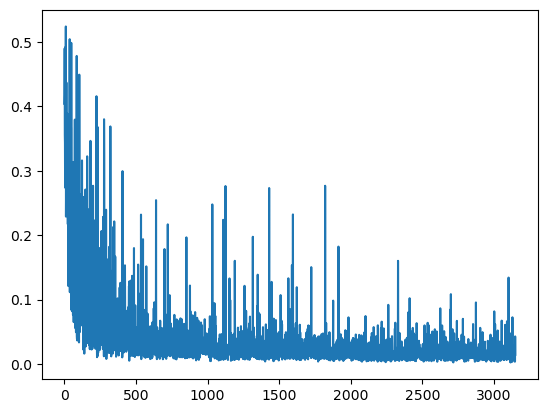

In [340]:
# plot training loss
plt.plot(np.array(losses_train_zip['30002']))

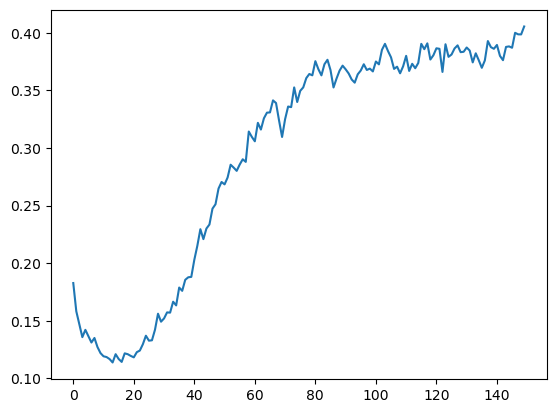

In [341]:
# plot test loss
plt.plot(np.array(losses_test_zip['30002']))

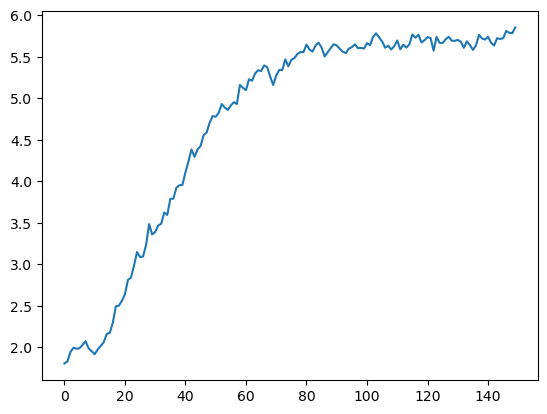

In [342]:
plt.plot(np.array(mape_test_zip['30002']))

In [254]:
# Test for optimal hidden layer dimension

# initialize dict to store loss values for each zip
losses_train_dict = {} 
losses_test_dict = {}
    
for dim in range(35, 56):
    
    model = SFR_MODEL(indim = 72, hdim = dim, outdim = 6)
    opt = Adam(model.parameters())
    batchsize = 3
    epochs = 150 # go though data 3x
    loss_fn = nn.MSELoss()

    # initialize list for losses
    losses_train = []
    losses_test = []

    for epoch in trange(epochs):

        # Access train set for zipcdode, create dataloader and set model to train
        sfr_train = zip_dict_train['30002']
        train_dl = DataLoader(sfr_train, batch_size = batchsize, shuffle = True, drop_last = True)
        model.train()

        for batch in train_dl:

            opt.zero_grad() # at the beginning of batch, zero out the optimizer

            # use inputs and outputs to make model prediction
            x = batch['X']
            y = batch['Y']
            y_hat = model(x)

            loss = loss_fn(y_hat, y) # calculate loss
            loss.backward() # calculate gradient of loss
            opt.step() # runs the optimizer and updates model params based on gradient
            losses_train.append(loss.cpu().detach().numpy()) # single value as a numpy

        # Access test set for zipcdode, create dataloader and set model to eval
        sfr_test = zip_dict_test['30002']
        test_dl = DataLoader(sfr_test, batch_size = batchsize, shuffle = True)
        model.eval()

        for batch in test_dl:
            with torch.no_grad():
                x = batch['X']
                y = batch['Y']
                y_hat = model(x)
                loss = loss_fn(y_hat, y)
                losses_test.append(loss.cpu().detach().numpy())

                if losses_test[-1] == min(losses_test):
                    torch.save(model, '../modelinfo/mlp_model_{}.pt".format(dim)')
                    torch.save({'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': opt.state_dict(),
                                'loss': loss.cpu().detach().numpy(),
                                }, "../modelinfo/model_info_{}.pt".format(dim))

    losses_train_dict[dim] = losses_train
    losses_test_dict[dim] = losses_test

100%|██████████████████████████████████████████████████| 150/150 [00:17<00:00,  8.44it/s]


In [256]:
hdim_loss = pd.DataFrame(columns = ['hdim', 'epoch', 'loss'])

for dim in range(35, 56):

    checkpoint = torch.load("model_info_{}.pt".format(dim))
    epoch = checkpoint['epoch']
    loss = checkpoint['loss'] 
    
    output_dim = []
    output_dim.append("hdim_{}.pt".format(dim))
    output_dim.append(epoch)
    output_dim.append(loss)
    hdim_loss.loc[len(hdim_loss)] = output_dim
    
hdim_loss

# highest epoch: 35 (hdim = 47)
# lowest loss: .035 (hdim = 37)

,hdim,epoch,loss
0,hdim_35.pt,19,0.079413064
1,hdim_36.pt,14,0.08461839
2,hdim_37.pt,13,0.035723954
3,hdim_38.pt,16,0.049715877
4,hdim_39.pt,18,0.13931565
5,hdim_40.pt,7,0.13384746
6,hdim_41.pt,22,0.08785221
7,hdim_42.pt,8,0.067629926
8,hdim_43.pt,20,0.09534913
9,hdim_44.pt,20,0.12443051


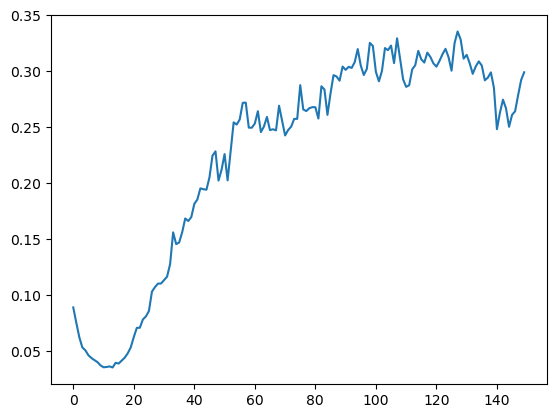

In [259]:
plt.plot(np.array(losses_test_dict[37]))

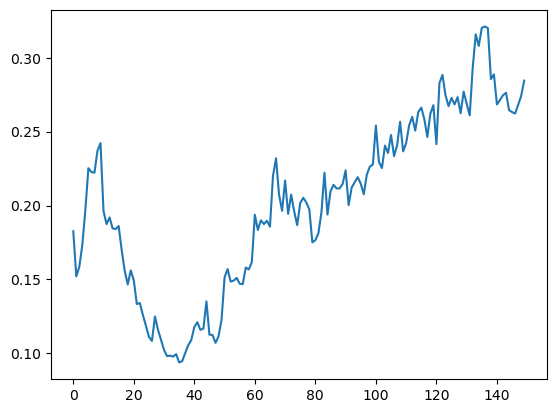

In [260]:
plt.plot(np.array(losses_test_dict[47]))

In [344]:
# create instance of model
# indim matches length of input vector
# outdim matches length of output vector
model = SFR_MODEL(indim = 72, hdim = 37, outdim = 6)

# start with Adam as optimizer
opt = Adam(model.parameters())
batchsize = 3
epochs = 150 # go though data 3x
loss_fn = nn.MSELoss()

In [ ]:
# Train/test loop: ALL ZIPS

# initialize dict to store loss values for each zip
losses_train_zip = {} 
losses_test_zip = {}
mape_test_zip = {}

for zipcode in df['census_zcta5_geoid'].unique():

    # initialize list for losses
    losses_train = []
    losses_test = []
    mape_test = []

    for epoch in trange(epochs):

        # Access train set for zipcdode, create dataloader and set model to train
        sfr_train = zip_dict_train[zipcode]
        train_dl = DataLoader(sfr_train, batch_size = batchsize, shuffle = True, drop_last = True)
        model.train()

        for batch in train_dl:

            opt.zero_grad() # at the beginning of batch, zero out the optimizer

            # use inputs and outputs to make model prediction
            x = batch['X']
            y = batch['Y']
            y_hat = model(x)

            loss = loss_fn(y_hat, y) # calculate loss
            loss.backward() # calculate gradient of loss
            opt.step() # runs the optimizer and updates model params based on gradient
            losses_train.append(loss.cpu().detach().numpy()) # single value as a numpy

        # Access test set for zipcdode, create dataloader and set model to eval
        sfr_test = zip_dict_test[zipcode]
        test_dl = DataLoader(sfr_test, batch_size = batchsize, shuffle = True)
        model.eval()

        for batch in test_dl:
            with torch.no_grad():
                x = batch['X']
                y = batch['Y']
                y_hat = model(x)
            
                mean_abs_percentage_error = MeanAbsolutePercentageError()
                mape = mean_abs_percentage_error(y_hat, y)
                mape_test.append(mape.cpu().detach().numpy())
                
                loss = loss_fn(y_hat, y)
                losses_test.append(loss.cpu().detach().numpy())

                if losses_test[-1] == min(losses_test):
                    torch.save(model, "../modelinfo/mlp_model_{}.pt".format(zipcode))
                    torch.save({'epoch': epoch,
                                'model_state_dict': model.state_dict(),
                                'optimizer_state_dict': opt.state_dict(),
                                'loss': loss.cpu().detach().numpy(),
                                }, "../modelinfo/model_info_{}.pt".format(zipcode))

    losses_train_zip[zipcode] = losses_train
    losses_test_zip[zipcode] = losses_test
    mape_test_zip[zipcode] = mape_test